In [1]:
import CairoMakie
import CSV
import Dates
import FASTX
import Infernal
import Makie
import Revise
import Rfam
import SamApp2024
using BioSequences: LongRNA
using BioSequences: RNA_Gap
using BioSequencesOneHot: onehot
using DataFrames: DataFrame
using LinearAlgebra: eigen
using NaNStatistics: nanmean
using NaNStatistics: nansum
using RestrictedBoltzmannMachines: free_energy
using Statistics: cor
using Statistics: mean

In [4]:
shape_data = SamApp.load_shapemapper_data_500v2_20240315();
RF00162_hits = SamApp.rfam_RF00162_hits();
rbm_energies = free_energy(SamApp.rbm2022(), onehot(shape_data.aligned_sequences));
aptamer_natural_distances = SamApp.hamming(onehot(shape_data.aligned_sequences), onehot(RF00162_hits));

In [5]:
@assert shape_data.aligned_sequences == map(LongRNA{4}, SamApp.all_designed_sequences_20230317().aligned_sequence)
@assert replace(SamApp.all_designed_sequences_20230317().origin, "infrared" => "Infrared") == shape_data.aptamer_origin

In [5]:
shape_data.conditions

7-element Vector{String}:
 "SAMAPS2_1M7_0-1SAM_5Mg_T30C_rep0"
 "SAMAPS2_1M7_1SAM_5Mg_T30C_rep0"
 "SAMAPS2_1M7_1SAM_5Mg_T55C_rep0"
 "SAMAPS2_1M7_noSAM_5Mg_T30C_rep0"
 "SAMAPS2_1M7_noSAM_5Mg_T55C_rep0"
 "SAMAPS2_1M7_noSAM_noMg_T30C_rep0"
 "SAMAPS2_1M7_noSAM_noMg_T55C_rep0"

In [6]:
conds_sam = [1,2];
conds_mg = [4];
conds_30C = [6];
the_conds = vcat(conds_sam, conds_mg, conds_30C)
shape_data.conditions[the_conds]

4-element Vector{String}:
 "SAMAPS2_1M7_0-1SAM_5Mg_T30C_rep0"
 "SAMAPS2_1M7_1SAM_5Mg_T30C_rep0"
 "SAMAPS2_1M7_noSAM_5Mg_T30C_rep0"
 "SAMAPS2_1M7_noSAM_noMg_T30C_rep0"

In [7]:
bps, nps, pks = SamApp.RF00162_sites_paired()

(bps = [1, 2, 3, 4, 5, 6, 7, 8, 13, 14  …  97, 100, 101, 102, 103, 104, 105, 106, 107, 108], nps = [9, 10, 11, 12, 18, 19, 20, 24, 32, 33  …  73, 74, 75, 87, 88, 89, 90, 91, 98, 99], pks = [25, 26, 27, 28, 77, 78, 79, 80])

In [8]:
ss_sites = SamApp.RF00162_sites_annotated_secondary_structure()

(bps = [1, 2, 3, 4, 5, 6, 7, 8, 13, 14  …  97, 100, 101, 102, 103, 104, 105, 106, 107, 108], nps = [9, 10, 11, 12, 18, 19, 20, 24, 32, 33  …  73, 74, 75, 87, 88, 89, 90, 91, 98, 99], pk = [25, 26, 27, 28, 77, 78, 79, 80], p1 = [1, 2, 3, 4, 5, 6, 7, 8, 101, 102, 103, 104, 105, 106, 107, 108], p2 = [13, 14, 15, 16, 17, 38, 39, 40, 41, 42, 21, 22, 23, 29, 30, 31], p3 = [43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72], p4 = [81, 82, 83, 84, 85, 86, 92, 93, 94, 95, 96, 97])

In [9]:
bps_reactivities = shape_data.shape_reactivities[bps, :, conds_sam];
nps_reactivities = shape_data.shape_reactivities[nps, :, conds_sam];
all_reactivities = shape_data.shape_reactivities[:, :, conds_sam];

shape_stats = SamApp.shape_basepair_log_odds_v4(;
    shape_data = shape_data,
    paired_reactivities = bps_reactivities,
    unpaired_reactivities = nps_reactivities,
    all_reactivities = all_reactivities,
    only_hq_profile = true, p_thresh = 1e-2, nsamples=5000
);

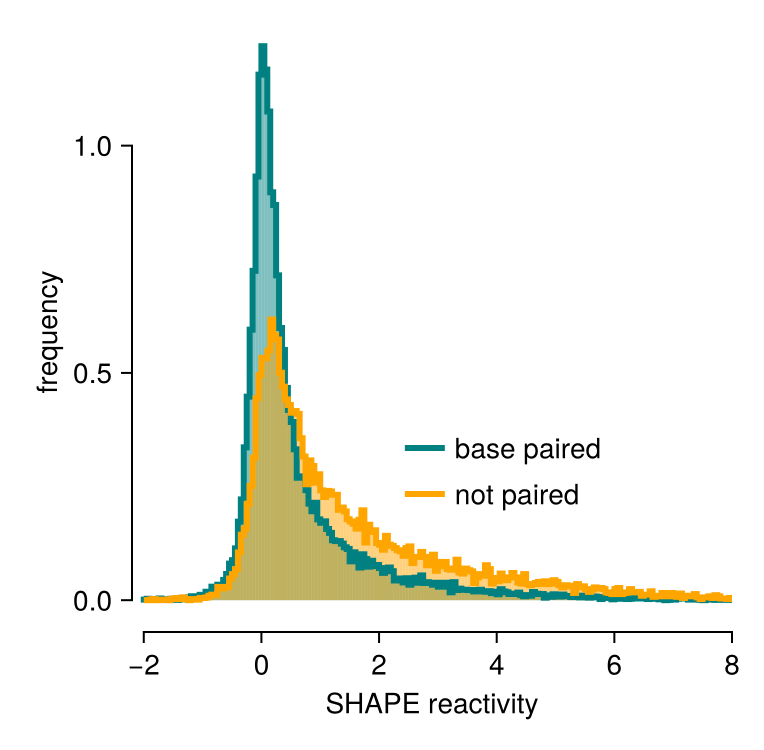

In [48]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=300, height=300, xlabel="SHAPE reactivity", ylabel="frequency", xgridvisible=false, ygridvisible=false, xticks=-2:2:8, yticks=0:0.5:1.5, xtrimspine=true, ytrimspine=true)
Makie.hist!(ax, filter(x -> -2 < x < 8, vec(bps_reactivities)), normalization=:pdf, bins=-2:0.05:8, color=(:teal, 0.5), gap=-0.01)
Makie.hist!(ax, filter(x -> -2 < x < 8, vec(nps_reactivities)), normalization=:pdf, bins=-2:0.05:8, color=(:orange, 0.5), gap=-0.01)
Makie.stephist!(ax, filter(x -> -2 < x < 8, vec(bps_reactivities)), label="base paired", normalization=:pdf, bins=-2:0.05:8, linewidth=3, color=:teal)
Makie.stephist!(ax, filter(x -> -2 < x < 8, vec(nps_reactivities)), label="not paired", normalization=:pdf, bins=-2:0.05:8, linewidth=3, color=:orange)
Makie.xlims!(-2.2, 8)
Makie.ylims!(-0.07, 1.25)
#Makie.axislegend(ax, framevisible=false, patchlabelgap=3, position=(-0.02, 1))
Makie.axislegend(ax, position=(0.7, 0.2), framevisible=false)
Makie.hidespines!(ax, :t, :r)

Makie.resize_to_layout!(fig)
Makie.save("Figures/SHAPE reactivities histograms 500.pdf", fig)
fig

In [10]:
_sites = SamApp.hallmark_sites_20230507;
println(_sites)

[25, 26, 27, 28, 77, 79, 34, 35, 36, 37, 73, 74, 75, 46, 47, 76, 100, 101, 102, 103, 104, 105]


In [11]:
p4_pos = union(81:86, 92:97); # P4 helix positions
# length of P4 segment for probed sequences
aptamer_p4_length = length(p4_pos) .- [count(seq[p4_pos] .== RNA_Gap) for seq = shape_data.aligned_sequences];

In [12]:
x_mg = nansum(shape_stats.shape_log_odds[_sites, :,  conds_mg]; dim=(1,3));
x_sam = nansum(shape_stats.shape_log_odds[_sites, :, conds_sam]; dim=(1,3));

In [13]:
_thresh = log(5)

1.6094379124341003

In [14]:
_responds_sam_yes = (x_mg .< -_thresh) .& (x_sam .> +_thresh);
_responds_sam_nop = (x_mg .> +_thresh) .| (x_sam .< -_thresh);

In [15]:
propertynames(shape_data)

(:shape_reactivities, :shape_reactivities_err, :shape_reactivities_indivnorm, :shape_reactivities_indivnorm_err, :shape_M, :shape_M_depth, :shape_M_stderr, :shape_U, :shape_U_depth, :shape_U_stderr, :shape_D, :shape_D_depth, :shape_D_stderr, :shape_raw_reactivities, :shape_raw_reactivities_err, :conditions, :aptamer_origin, :aptamer_criteria, :aligned_sequences)

In [17]:
df = DataFrame(;
    aligned_sequences = shape_data.aligned_sequences,
    aptamer_origin = shape_data.aptamer_origin,
    switch_yes = _responds_sam_yes,
    switch_no = _responds_sam_nop
)

Row,aligned_sequences,aptamer_origin,switch_yes,switch_no
,LongSequ…,String,Bool,Bool
1,GUCUUAUACUGAGCGGG-GAGGGACAGGCCCUGUGAACCCGCGGCAACCUCCCAUA---UUGGACAGGUGCUAAUUCCCACAGGGCAAGUGGCCCUGAGAGAUAAGAU,infernal,false,true
2,UUUUU----AGAGUAGCGGAGGGAUUGGCCCGAUGAAGCUACGGCAACCUCCUC----CAAGGAAAGGUGCCAAAUCUAGCGGAUAGUGAACAUCCGAAA---AAGAU,infernal,false,true
3,CCCUCAUCAAGAAUGGUGGAGGGACUGGCCCUAUGAAACC-UAGCAACCCCCGGAU----CGGGAGGGUGCUAAUUCCAGUCCCAU-----AUGGGCAGAGAUGAGGA,infernal,false,true
4,UAGUCAUCCAGAGAGACAGAGGGACUGGACCAAUGAUGUCUCGGCAACGGCGCCACAUACGCGCACUGUGCCAACUCCUACAUGA-GUGUG-UCAUGACAGAUGAACU,infernal,false,true
5,CACUUAUAAAGAGACGCGGAGGGACAGGCCCAAUGAAGCG-CGCCAACCCUCAUAAU-GUUGAGAAGGUGGUGAUUCCUGCG------AAA----CGAAAUAUAAGGG,infernal,false,true
6,UUUUUAUCAAGAGCGGUGGAGGGAUUUGCCCUUUGAAACC-CGGCAACCUGCAGGCU---UGUUAAGGUGCUAACUCCGGUAAACUGAGAAAGUUUACAAGAUAAGAA,infernal,false,true
7,CGGUCAUCCAGAGAAACCAAGGGAAAGGCCCGAUGAAGUUUCGGCAACCCGAAAUUCAGCUUUGUAGGUGCUAACUCCAGCACGAC--AGGUUCGUGGGAGAUGACGG,infernal,false,false
8,AUCUUAUCGCGAGCAGUUGAGGGAUUGGCCCGGUGAAGCU-CGGCAACCUCUUAACCUACGAGAAAGGUGCUAAUUCCAG------------------GAGAUAAGAU,infernal,false,true
9,UACCUAUUCAGAGCGGCGGAGGGACUGGCUCUAUGAUACC-CGGCAACGGCAAGAAAAAAUUGCA-CGUGCUACAUUCGGCCCGUUUGGAUUGCGGGAGAAAUAGGGA,infernal,false,false


In [15]:
CSV.write("/workspaces/SamApp.jl/data/500_analysis.csv", df)

"/workspaces/SamApp.jl/data/500_analysis.csv"

In [16]:
propertynames(shape_data)

(:shape_reactivities, :shape_reactivities_err, :shape_reactivities_indivnorm, :shape_reactivities_indivnorm_err, :shape_M, :shape_M_depth, :shape_M_stderr, :shape_U, :shape_U_depth, :shape_U_stderr, :shape_D, :shape_D_depth, :shape_D_stderr, :shape_raw_reactivities, :shape_raw_reactivities_err, :conditions, :aptamer_origin, :aptamer_criteria, :aligned_sequences)

In [17]:
select!(df, [:aptamer_names, :aptamer_ids, :aptamer_origin, :aligned_sequence, :responsive_to_SAM_repl0, :unresponsive_to_SAM_repl0]);

UndefVarError: UndefVarError: `df` not defined

In [18]:
function successes_tuple_str(yes::Int, no::Int)
    p_succ = yes / (yes + no)
    err = sqrt(p_succ * (1 - p_succ) / (yes + no))
    perc = round(100p_succ; digits=1)
    perc_err = round(100err; digits=1)
    return "conclusive: $(yes + no) | responsive: $yes ($perc ± $perc_err %) | not responsive: $no ($(round(100-perc; digits=1)) ± $perc_err %)"
end

successes_tuple_str (generic function with 1 method)

In [18]:
rbm_seqs = findall(shape_data.aptamer_origin .== "rbm");
inf_seqs = findall(shape_data.aptamer_origin .== "infernal");

inf_untangled_seqs = findall(shape_data.aptamer_criteria .== "perm");
inf_uniform_seqs = findall(shape_data.aptamer_criteria .== "uniform");

rbm_p4_seqs = findall(shape_data.aptamer_criteria .== "p4");
@assert rbm_p4_seqs ⊆ rbm_seqs

@assert inf_untangled_seqs ⊆ inf_seqs
@assert inf_uniform_seqs ⊆ inf_seqs
@assert sort(inf_untangled_seqs ∪ inf_uniform_seqs) == inf_seqs
@assert isempty(inf_untangled_seqs ∩ inf_uniform_seqs)

In [19]:
# CM model from Rfam (this has the noisy floor!)
Rfam_cm = Infernal.cmfetch(Rfam.cm(), "RF00162");

In [20]:
RF00162_seed_stk = Infernal.esl_afetch(Rfam.seed(), "RF00162")
RF00162_seed_match_cols = findall(≠('.'), SamApp.stockholm_ss(RF00162_seed_stk.out));
RF00162_seed_afa = Infernal.esl_reformat("AFA", RF00162_seed_stk.out; informat="STOCKHOLM") # WARNING: this has inserts marked as '-'
RF00162_seed_records = collect(FASTX.FASTA.Reader(open(RF00162_seed_afa.out)))
RF00162_seed_seqs_noinserts = [FASTX.sequence(record)[RF00162_seed_match_cols] for record in RF00162_seed_records];
RF00162_seed_seqs_noinserts = LongRNA{4}.(RF00162_seed_seqs_noinserts);

# trimmed (no inserts) aligned fasta
RF00162_hits_afa = Infernal.cmalign(Rfam_cm.out, Rfam.fasta_file("RF00162"); matchonly=true, outformat="AFA");
# these are already aligned and without inserts
RF00162_hits_sequences = FASTX.sequence.(FASTX.FASTA.Reader(open(RF00162_hits_afa.out)));
@assert only(unique(length.(RF00162_hits_sequences))) == 108
RF00162_hits_sequences = LongRNA{4}.(RF00162_hits_sequences);

In [21]:
# sites that have some non-zero fluctuations
# We need to separate frozen sites below because otherwise cor and eigen give NaN, infinities, and fail
_variable_sites_flag = vec(all(0 .< mean(SamApp.onehot(RF00162_hits_sequences); dims=3) .< 1; dims=1));
_variable_sites = findall(_variable_sites_flag);
RF00162_hits_var_sites_only = SamApp.onehot(RF00162_hits_sequences)[:, _variable_sites, :];

RF00162_hits_cor = cor(reshape(RF00162_hits_var_sites_only, :, size(RF00162_hits_var_sites_only, 3)); dims=2);
RF00162_hits_eig = eigen(RF00162_hits_cor);

# remap the variable sites eigenvectors back to the original consensus sequence numbering
RF00162_hits_eigvec = zeros(5, 108, size(RF00162_hits_eig.vectors, 1))
for n in 1:size(RF00162_hits_eig.vectors, 1)
    vec(view(RF00162_hits_eigvec, :, _variable_sites, n)) .= RF00162_hits_eig.vectors[:, n]
end

In [23]:
shape_sequences_onehot = SamApp.onehot(LongRNA{4}.(shape_data.aligned_sequences));

__proj_500 = reshape(shape_sequences_onehot, 5*108, :)' * reshape(RF00162_hits_eigvec, 5*108, :);
__proj_hits = reshape(SamApp.onehot(RF00162_hits_sequences), 5*108, :)' * reshape(RF00162_hits_eigvec, 5*108, :);

In [22]:
unique(shape_data.aptamer_origin)

3-element Vector{String}:
 "infernal"
 "rbm"
 "Infrared"

In [31]:
# structural motifs
struct_bands = [
    (; x0=0.5, xf=8.5, color="blue", alpha=0.1), # P1
    (; x0=100.5, xf=108.5, color="blue", alpha=0.1), # P1
    (; x0=11.5, xf=16.5, color="green", alpha=0.1), # P2
    (; x0=20.5, xf=23.5, color="green", alpha=0.1), # P2
    (; x0=28.5, xf=31.5, color="green", alpha=0.1), # P2
    (; x0=37.5, xf=42.5, color="green", alpha=0.1), # P2
    (; x0=42.5, xf=46.5, color="orange", alpha=0.1), # P3
    (; x0=47.5, xf=53.5, color="orange", alpha=0.1), # P3
    (; x0=60.5, xf=64.5, color="orange", alpha=0.1), # P3
    (; x0=66.5, xf=72.5, color="orange", alpha=0.1), # P3
    (; x0=80.5, xf=86.5, color="teal", alpha=0.1), # P4
    (; x0=91.5, xf=97.5, color="teal", alpha=0.1), # P4
    (; x0=24.5, xf=28.5, color="red", alpha=0.1), # Pk
    (; x0=76.5, xf=80.5, color="red", alpha=0.1), # Pk
];

In [33]:
_responds_sam_yes[284], _responds_sam_nop[284]

(true, false)

In [37]:
collect((0:10:60)./108)

7-element Vector{Float64}:
 0.0
 0.09259259259259259
 0.18518518518518517
 0.2777777777777778
 0.37037037037037035
 0.46296296296296297
 0.5555555555555556

In [ ]:
0.1:0.1:0.6

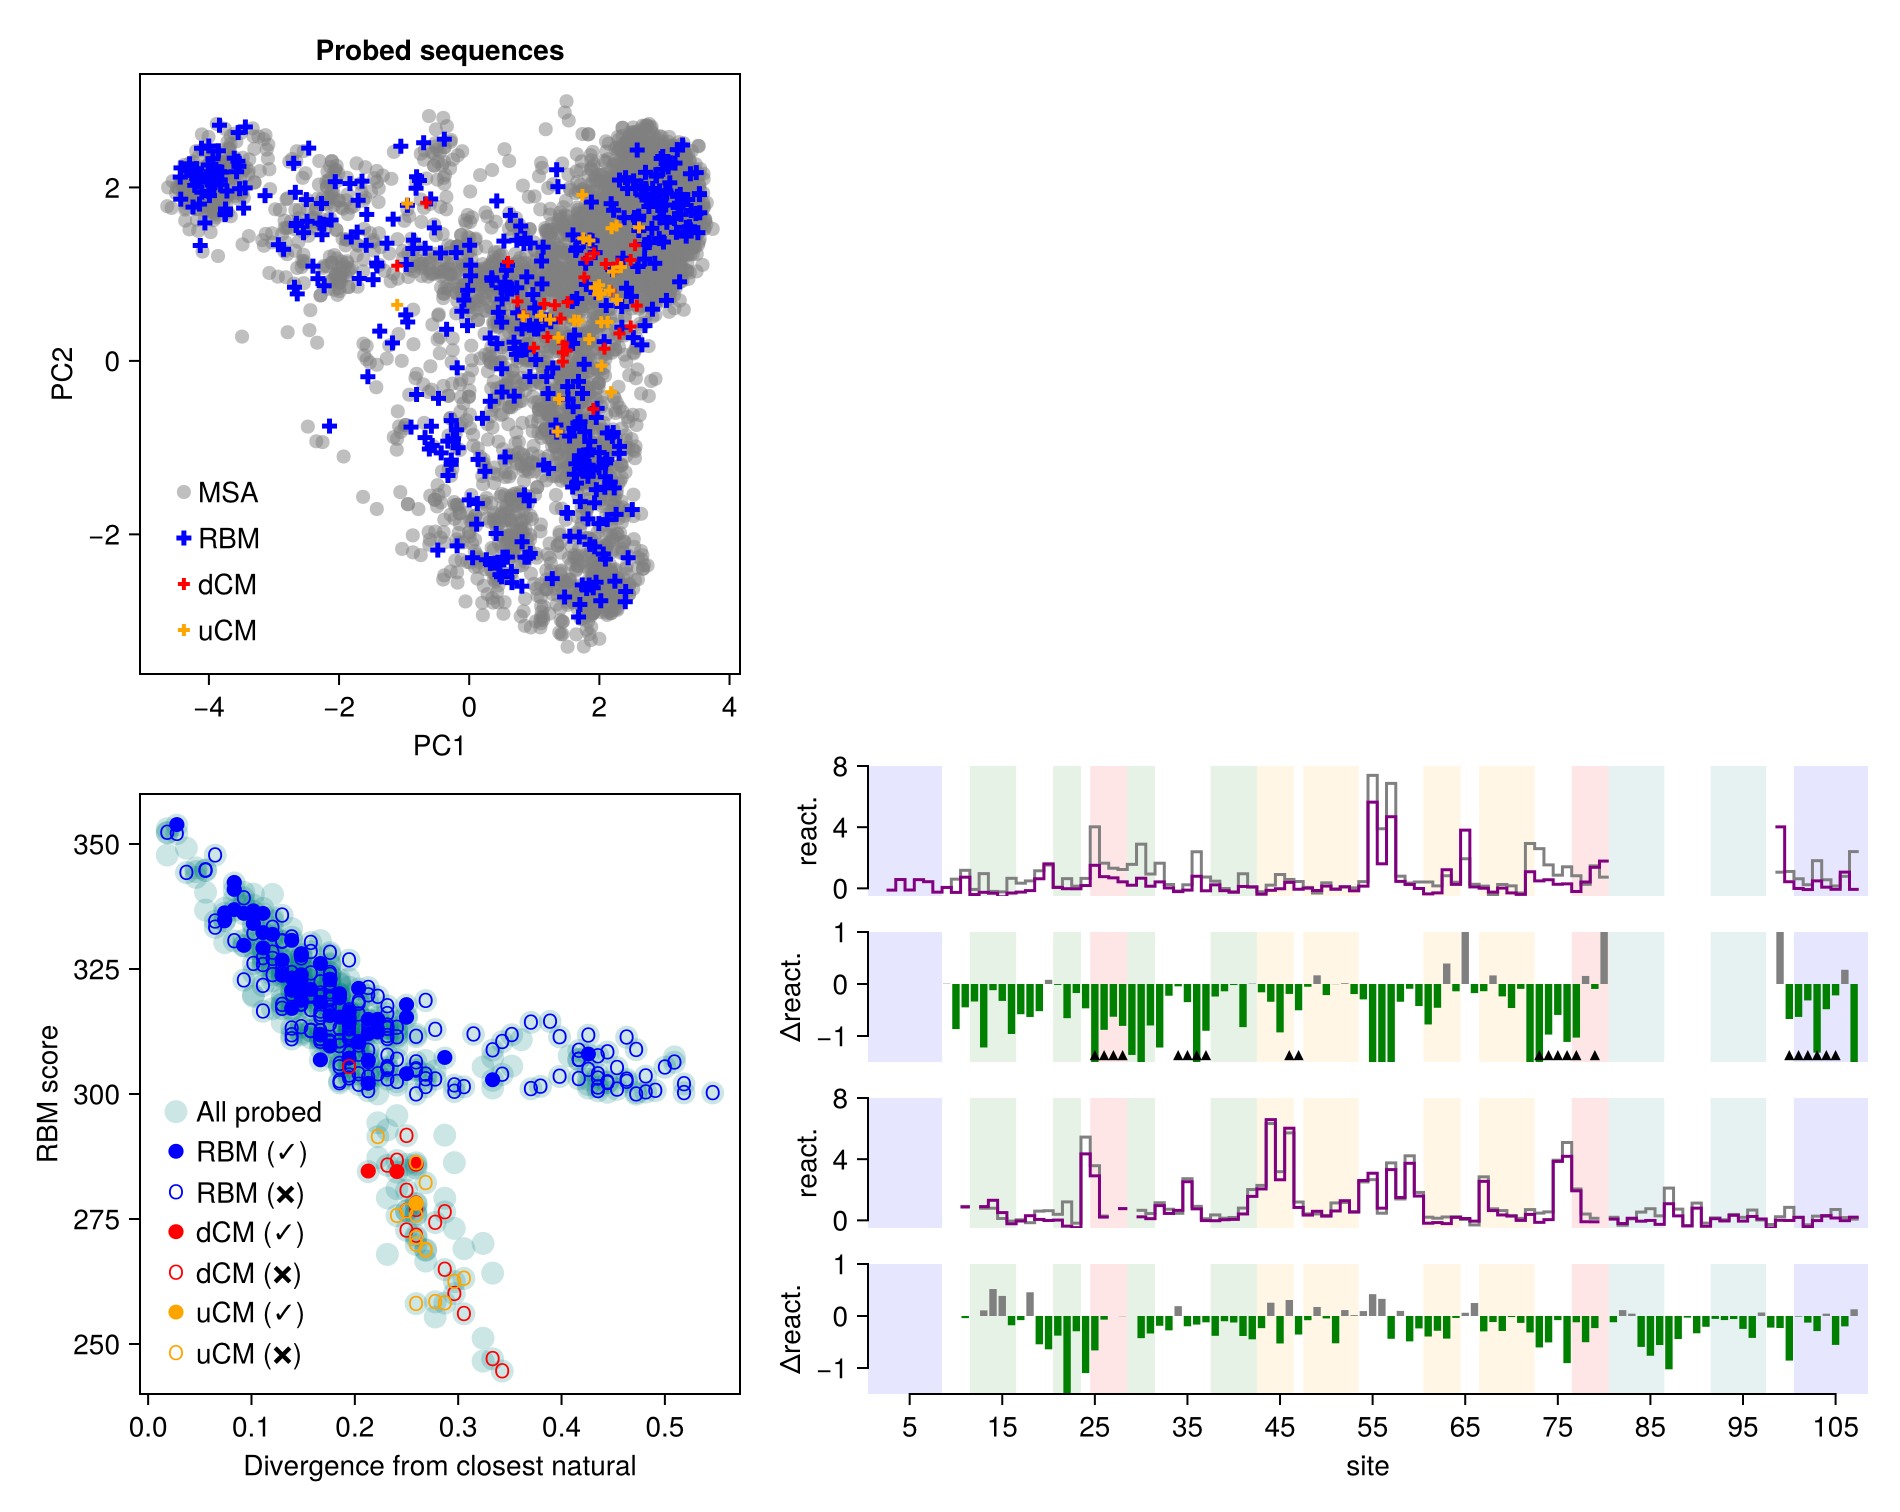

In [29]:
fig = Makie.Figure()

ax = Makie.Axis(fig[1,1][1,1], xlabel="PC1", ylabel="PC2", width=300, height=300, xgridvisible=false, ygridvisible=false, title="Probed sequences")
Makie.scatter!(ax, __proj_hits[:, end], __proj_hits[:, end - 1], markersize=10, color=(:gray, 0.5), label="MSA")
# Makie.scatter!(ax,
#     __proj_500[(aptamer_p4_length .< 1) .& _responds_sam_yes, end],
#     __proj_500[(aptamer_p4_length .< 1) .& _responds_sam_yes, end - 1],
#     markersize=15, color=:orange, marker='●'
# )
Makie.scatter!(ax, 
    __proj_500[shape_data.aptamer_origin .== "rbm", end],
    __proj_500[shape_data.aptamer_origin .== "rbm", end - 1],
    markersize=10, color=:blue, label="RBM", marker=:cross
)
Makie.scatter!(ax,
    __proj_500[inf_uniform_seqs, end],
    __proj_500[inf_uniform_seqs, end - 1],
    markersize=8, color=:red, label="dCM", marker=:cross
)
Makie.scatter!(ax,
    __proj_500[inf_untangled_seqs, end],
    __proj_500[inf_untangled_seqs, end - 1],
    markersize=8, color=:orange, label="uCM", marker=:cross
)
Makie.axislegend(ax, position=:lb, framevisible=false, patchlabelgap=-3)

ax = Makie.Axis(fig[1,1][2,1], width=300, height=300, xlabel="Divergence from closest natural", ylabel="RBM score", xticks=0:0.1:0.6, yticks=200:25:350, xgridvisible=false, ygridvisible=false)
Makie.scatter!(ax, vec(minimum(aptamer_natural_distances; dims=2)) / 108, -rbm_energies, markersize=15, color=(:teal, 0.2), marker='●', label="All probed")
Makie.scatter!(ax, vec(minimum(aptamer_natural_distances[rbm_seqs ∩ findall(_responds_sam_yes), :]; dims=2)) / 108, -rbm_energies[rbm_seqs ∩ findall(_responds_sam_yes)], markersize=10, color=:blue, marker='●', label="RBM (✓)")
Makie.scatter!(ax, vec(minimum(aptamer_natural_distances[rbm_seqs ∩ findall(_responds_sam_nop), :]; dims=2)) / 108, -rbm_energies[rbm_seqs ∩ findall(_responds_sam_nop)], markersize=10, color=:blue, marker='O', label="RBM (❌)")
# Makie.scatter!(ax, vec(minimum(aptamer_natural_distances[inf_seqs ∩ findall(_responds_sam_yes), :]; dims=2)), -rbm_energies[inf_seqs ∩ findall(_responds_sam_yes)], markersize=10, color=:red, marker='●', label="CM (✓)")
# Makie.scatter!(ax, vec(minimum(aptamer_natural_distances[inf_seqs ∩ findall(_responds_sam_nop), :]; dims=2)), -rbm_energies[inf_seqs ∩ findall(_responds_sam_nop)], markersize=10, color=:red, marker='O', label="CM (❌)")
Makie.scatter!(ax, vec(minimum(aptamer_natural_distances[inf_uniform_seqs ∩ findall(_responds_sam_yes), :]; dims=2)) / 108, -rbm_energies[inf_uniform_seqs ∩ findall(_responds_sam_yes)], markersize=10, color=:red, marker='●', label="dCM (✓)")
Makie.scatter!(ax, vec(minimum(aptamer_natural_distances[inf_uniform_seqs ∩ findall(_responds_sam_nop), :]; dims=2)) / 108, -rbm_energies[inf_uniform_seqs ∩ findall(_responds_sam_nop)], markersize=10, color=:red, marker='O', label="dCM (❌)")
Makie.scatter!(ax, vec(minimum(aptamer_natural_distances[inf_untangled_seqs ∩ findall(_responds_sam_yes), :]; dims=2)) / 108, -rbm_energies[inf_untangled_seqs ∩ findall(_responds_sam_yes)], markersize=10, color=:orange, marker='●', label="uCM (✓)")
Makie.scatter!(ax, vec(minimum(aptamer_natural_distances[inf_untangled_seqs ∩ findall(_responds_sam_nop), :]; dims=2)) / 108, -rbm_energies[inf_untangled_seqs ∩ findall(_responds_sam_nop)], markersize=10, color=:orange, marker='O', label="uCM (❌)")
Makie.ylims!(ax, 240, 360)
Makie.axislegend(ax, position=(-0.02, -0.01), framevisible=false, nbanks=1, colgap=1, rowgap=0.1, patchlabelgap=0)


_dummy_axis = Makie.Axis(fig[1,2][0,1])
Makie.hidespines!(_dummy_axis, :t, :b, :l, :r)
Makie.hidexdecorations!(_dummy_axis)
Makie.hideydecorations!(_dummy_axis)

_width = 500
_height = 65

# example of no P4
n_ex = 116

_R_mg = shape_data.shape_reactivities[:, n_ex, only(conds_mg)]
_R_sam = shape_data.shape_reactivities[:, n_ex, conds_sam[2]]

ax_react_1 = Makie.Axis(fig[1,2][1,1]; valign=:bottom, width=_width, height=_height, xticks=5:10:108, ylabel="react.", xgridvisible=false, ygridvisible=false, yticks=0:4:8, xtrimspine=true, ytrimspine=true)
for (x0, xf, color, alpha) = struct_bands
    Makie.vspan!(ax_react_1, x0, xf; color=(color, alpha))
end
Makie.stairs!(ax_react_1, 1:108, _R_mg, color=:gray, step=:center, label="no SAM")
Makie.stairs!(ax_react_1, 1:108, _R_sam, color=:purple, step=:center, label="with SAM")
Makie.hidespines!(ax_react_1, :t, :r, :b)
Makie.hidexdecorations!(ax_react_1)
#Makie.axislegend(ax_react_1, position=(0.0, -13), framevisible=false)

ax_diff_1 = Makie.Axis(fig[1,2][2,1]; valign=:bottom, width=_width, height=_height, xticks=5:10:108, xlabel="site", ylabel="Δreact.", xgridvisible=false, ygridvisible=false, yticks=-1:1, xtrimspine=true, ytrimspine=true)
for (x0, xf, color, alpha) = struct_bands
    Makie.vspan!(ax_diff_1, x0, xf; color=(color, alpha))
end
Makie.barplot!(ax_diff_1, 1:108, _R_sam - _R_mg, color=ifelse.(_R_sam - _R_mg .< 0, :green, :gray))
Makie.scatter!(ax_diff_1, _sites, -1.4one.(_sites), markersize=7, color=:black, marker=:utriangle)
Makie.xlims!(ax_diff_1, 0, 109)
Makie.hidespines!(ax_diff_1, :r, :b, :t)
Makie.hidexdecorations!(ax_diff_1)
#Makie.scatter!(ax_diff_1, _sites, -0.2one.(_sites), color=:blue, markersize=5)

# example distant
n_ex = 284

_R_mg = shape_data.shape_reactivities[:, n_ex, only(conds_mg)]
_R_sam = shape_data.shape_reactivities[:, n_ex, conds_sam[2]]

ax_react_2 = Makie.Axis(fig[1,2][3,1]; valign=:bottom, width=_width, height=_height, xticks=5:10:108, yticks=0:4:8, ylabel="react.", xgridvisible=false, ygridvisible=false, xtrimspine=true, ytrimspine=true)
for (x0, xf, color, alpha) = struct_bands
    Makie.vspan!(ax_react_2, x0, xf; color=(color, alpha))
end
Makie.stairs!(ax_react_2, 1:108, _R_mg, color=:gray, step=:center, label="no SAM")
Makie.stairs!(ax_react_2, 1:108, _R_sam, color=:purple, step=:center, label="with SAM")
Makie.hidespines!(ax_react_2, :t, :r, :b)
Makie.hidexdecorations!(ax_react_2)

ax_diff_2 = Makie.Axis(fig[1,2][4,1]; valign=:bottom, width=_width, height=_height, xticks=5:10:108, yticks=-1:1, xlabel="site", ylabel="Δreact.", xgridvisible=false, ygridvisible=false, xtrimspine=true, ytrimspine=true)
for (x0, xf, color, alpha) = struct_bands
    Makie.vspan!(ax_diff_2, x0, xf; color=(color, alpha))
end
Makie.barplot!(ax_diff_2, 1:108, _R_sam - _R_mg, color=ifelse.(_R_sam - _R_mg .< 0, :green, :gray))
Makie.hidespines!(ax_diff_2, :r, :t)
#Makie.scatter!(ax_diff_2, _sites, -0.2one.(_sites), color=:blue, markersize=5)

Makie.linkxaxes!(ax_react_1, ax_diff_1)
Makie.linkxaxes!(ax_react_2, ax_diff_2)
Makie.linkyaxes!(ax_react_1, ax_react_2)
Makie.linkyaxes!(ax_diff_1, ax_diff_2)

Makie.ylims!(ax_diff_1, -1.5, 1)
Makie.ylims!(ax_diff_2, -1.5, 1)

Makie.ylims!(ax_react_1, -0.5, 8)
Makie.ylims!(ax_react_2, -0.5, 8)

Makie.xlims!(ax_react_1, 0.5, 108.5)
Makie.xlims!(ax_react_2, 0.5, 108.5)
Makie.xlims!(ax_diff_1,  0.5, 108.5)
Makie.xlims!(ax_diff_2,  0.5, 108.5)

Makie.resize_to_layout!(fig)
#Makie.save("Figures/500 aptamers.pdf", fig)
fig